Codes in this jupyter notebook shows work on ZVA05 (SAP data) from Jan 1, 2017 - May 31, 2015.

The overall goal is to predict monthly sum order quantity for each master SKU.

Dealers from sales office 'HYB' and 'STD' are segmented using the entire ZVA05 dataset into 4 volume groups: Small, Medium, Large and X-Large.

Algorithm tested: OLS, WLS, KNN, random forest.

Main conclusions:
- data is not homoskedastic, cannot use OLS regression, Pearson correlation, t-test and p-value.
- segment method is wrong (mix of training and testing data)

In [15]:
import pandas as pd
import numpy as np
import datetime
import copy
import pyodbc
import sys
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import levene, bartlett

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
# retrieve volume segmented data on product category level
%store -r aggr_data
aggr_data.sample(2)

,SalesOffice,Order_Type,Order_Qty,Overall_Credit_Status,Delivery_Block,Billing_Block,Block_flag,Overall_Credit_Status_Desc,ProductCategory,MasterSKU,...,State,Zipcode,Country,District,waiting_days,wait,dealer_volume_group,year,month,monthly_sum_Order_Qty
460374,1,2,12.0,1,0,0,0,1,2,17,...,17,5287,5,18,0,1,0,2018,1,541354.0
363313,1,2,4.0,1,0,0,0,1,0,13,...,14,1462,5,12,0,1,0,2017,10,653.0


In [3]:
aggr_data.columns

Index(['SalesOffice', 'Order_Type', 'Order_Qty', 'Overall_Credit_Status',
       'Delivery_Block', 'Billing_Block', 'Block_flag',
       'Overall_Credit_Status_Desc', 'ProductCategory', 'MasterSKU', 'Color',
       'City', 'State', 'Zipcode', 'Country', 'District', 'waiting_days',
       'wait', 'dealer_volume_group', 'year', 'month',
       'monthly_sum_Order_Qty'],
      dtype='object')

In [5]:
df = aggr_data.drop(columns=['monthly_sum_Order_Qty'])

In [6]:
df.columns

Index(['SalesOffice', 'Order_Type', 'Order_Qty', 'Overall_Credit_Status',
       'Delivery_Block', 'Billing_Block', 'Block_flag',
       'Overall_Credit_Status_Desc', 'ProductCategory', 'MasterSKU', 'Color',
       'City', 'State', 'Zipcode', 'Country', 'District', 'waiting_days',
       'wait', 'dealer_volume_group', 'year', 'month'],
      dtype='object')

In [12]:
df.columns[18]

'dealer_volume_group'

### Calculate response variable (Y)
Based on each dealer's volume (sum of Order_Qty / # of months being a customer) grouping, the response Y is each volume group's monthly sum of Order_Qty in a given month (regardless of year).

update_monthly_sum() adds a column to the end of each row indicating the monthly sum of Order_Qty of this specific masterSKU ordered by dealers from the same volume group.

In [17]:
def update_monthly_sum(dFrame):
        
    new_dFrame = dFrame.copy()
    
    # column to the end of the dataframe
    new_dFrame['monthly_sum_Order_Qty'] = np.nan
    
    hi = len(dFrame)

    for i, row in dFrame.iterrows():
        
        # find the same MasterSKU sold in the same month (regardless of year)
        # to the same dealer volume group
        subset = dFrame.loc[(dFrame['year'] == row[19]) 
                            & (dFrame['month'] == row[20]) 
                            & (dFrame['MasterSKU'] == row[9])
                            & (dFrame['dealer_volume_group'] == row[18])]

        # calculate their sum Order_Qty
        subset_order_sum = subset['Order_Qty'].sum(min_count=1)
            
        # update sum of Order_Qty for all relevant rows
        new_dFrame.loc[(
                        (np.isnan(new_dFrame['monthly_sum_Order_Qty']))
                        & (dFrame['year'] == row[19]) 
                        & (dFrame['month'] == row[20]) 
                        & (dFrame['MasterSKU'] == row[9])
                        & (dFrame['dealer_volume_group'] == row[18])
                        ), 'monthly_sum_Order_Qty'] = subset_order_sum
            
        # status update
        if (i % 1000) == 0 and i <= hi:
            sys.stdout.write('\r'+"{0:.3%}".format(i/hi))
            sys.stdout.flush()
            
    return new_dFrame

In [18]:
aggr_data_masterSKU = update_monthly_sum(df)

99.892%

In [19]:
aggr_data_masterSKU.shape

(602653, 22)

In [23]:
aggr_data_masterSKU.columns

Index(['SalesOffice', 'Order_Type', 'Order_Qty', 'Overall_Credit_Status',
       'Delivery_Block', 'Billing_Block', 'Block_flag',
       'Overall_Credit_Status_Desc', 'ProductCategory', 'MasterSKU', 'Color',
       'City', 'State', 'Zipcode', 'Country', 'District', 'waiting_days',
       'wait', 'dealer_volume_group', 'year', 'month',
       'monthly_sum_Order_Qty'],
      dtype='object')

In [21]:
aggr_data_masterSKU.sample(5)

,SalesOffice,Order_Type,Order_Qty,Overall_Credit_Status,Delivery_Block,Billing_Block,Block_flag,Overall_Credit_Status_Desc,ProductCategory,MasterSKU,...,State,Zipcode,Country,District,waiting_days,wait,dealer_volume_group,year,month,monthly_sum_Order_Qty
209813,1,2,6.0,1,0,0,0,1,2,26,...,29,2731,5,32,57,2,0,2017,7,128391.0
336028,1,2,1.0,1,0,0,0,1,3,40,...,9,4696,5,59,0,1,1,2017,9,848.0
473218,1,2,12.0,1,0,0,0,1,2,24,...,54,1007,5,53,0,1,0,2018,2,104892.0
142312,1,2,12.0,3,0,0,0,1,2,25,...,35,938,5,38,21,2,1,2017,5,1264.0
505634,0,2,24.0,1,0,0,0,1,2,24,...,29,2680,5,32,0,1,3,2018,2,149472.0


In [22]:
%store aggr_data_masterSKU

Stored 'aggr_data_masterSKU' (DataFrame)


In [184]:
aggr_data_masterSKU.dealer_volume_group.unique()

array([2, 0, 1, 3], dtype=int64)

#### Check if any masterSKU has monthly Order_Qty sum equal to 0

In [2]:
%store -r aggr_data_masterSKU
len(aggr_data_masterSKU.loc[aggr_data_masterSKU.monthly_sum_Order_Qty == 0])

0

In [3]:
aggr_data_masterSKU.sample(5)

,SalesOffice,Order_Type,Order_Qty,Overall_Credit_Status,Delivery_Block,Billing_Block,Block_flag,Overall_Credit_Status_Desc,ProductCategory,MasterSKU,...,State,Zipcode,Country,District,waiting_days,wait,dealer_volume_group,year,month,monthly_sum_Order_Qty
570399,1,2,6.0,1,0,0,0,1,2,26,...,24,3525,5,25,0,1,0,2018,4,24221.0
361576,1,2,4.0,1,0,0,0,1,2,25,...,14,1737,5,13,0,1,0,2017,10,21794.0
420356,1,2,12.0,1,0,0,0,1,2,24,...,8,5164,5,54,0,1,0,2017,12,58610.0
148796,1,2,24.0,1,0,0,0,1,2,26,...,45,2583,5,45,0,1,0,2017,5,47464.0
269775,1,2,6.0,1,0,0,0,1,2,24,...,35,967,5,15,0,1,0,2017,7,168184.0


#### check column datatypes

In [88]:
aggr_data_masterSKU.dtypes

SalesOffice                     int64
Order_Type                      int64
Order_Qty                     float64
Overall_Credit_Status           int64
Delivery_Block                  int64
Billing_Block                   int64
Block_flag                      int64
Overall_Credit_Status_Desc      int64
ProductCategory                 int64
MasterSKU                       int64
Color                           int64
City                            int64
State                           int64
Zipcode                         int64
Country                         int64
District                        int64
waiting_days                    int64
wait                            int64
dealer_volume_group             int64
year                            int64
month                           int64
monthly_sum_Order_Qty         float64
dtype: object

### Visualize Y
Like the dependent variable in ProductCategory_Volume_segmentation, the distribution of MasterSKU-level response variable is far from normal distribution and likely requires Box-Cox transformation to achieve better results.

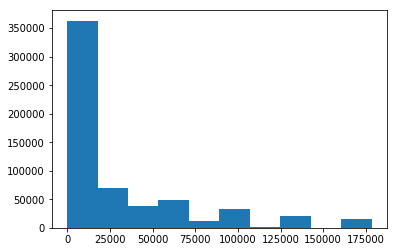

In [56]:
def visualize_Y_dist():
    Y = aggr_data_masterSKU['monthly_sum_Order_Qty'].values.reshape(-1,1)
    plt.hist(Y)
visualize_Y_dist()

### Split all data and use 20% to start initial test

In [67]:
def calculate_adj_r2(r2_score, n, p):
    return 1 - (1-r2_score)*(n-1)/(n-p-1)

def mape(Y_test, Y_pred):
    Y_test, Y_pred = np.array(Y_test), np.array(Y_pred)
    Y_test = [y if y != 0 else 0.01 for y in Y_test]
    return np.mean((np.abs((Y_test-Y_pred)/Y_test))) * 100

def split_data(data, sample_size):
    X = data[['ProductCategory', 'MasterSKU', 'dealer_volume_group', 'month']].values
    Y = data['monthly_sum_Order_Qty'].values.reshape(-1,1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                        test_size=(1-sample_size),
                                                        random_state=42)    
    return X_train, Y_train

def cross_val_mape(model, X_, Y_, fold=5, rand_seed=None):
    
    X_train, X_test, Y_train, Y_test = [],[],[],[]
    
    kf = KFold(n_splits=fold, random_state=rand_seed)
    for train_indices, test_indices in kf.split(X_, Y_):
        X_train, X_test = X_[train_indices], X_[test_indices]
        Y_train, Y_test = Y_[train_indices], Y_[test_indices]
    
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    mape_score = mape(Y_test, Y_pred)
    
    return mape_score

In [68]:
%store -r aggr_data_masterSKU
X, Y = split_data(aggr_data_masterSKU, sample_size=0.2)
len(X) == len(Y)
print('Sample size:',len(X))

Sample size: 120530


In [6]:
aggr_data_masterSKU.shape

(602653, 22)

In [16]:
%store -r aggr_data_masterSKU
X_80, Y_80 = split_data(aggr_data_masterSKU, sample_size=0.8)
print('sample size:', len(X_80), len(X) == len(Y))

sample size: 482122 True


### OLS Linear Regression

In [4]:
def ols_ttest(X, Y, boxcox_transform=False):
    
    # center and scale X; box-cox transform Y
    # X = normalize(X,norm='l2', copy=False) # no need to normalize for OLS
    sc = StandardScaler()
    X_ = sc.fit_transform(X_)
    if boxcox_transform:
        Y_, _ = boxcox(Y_)

    # fit linear regression model
    X_ = sm.add_constant(X_)
    mod = sm.OLS(Y_, X_)
    res = mod.fit()
    
    print(res.summary())

In [112]:
ols_ttest(X,Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     7906.
Date:                Thu, 12 Jul 2018   Prob (F-statistic):               0.00
Time:                        11:32:14   Log-Likelihood:            -1.4377e+06
No. Observations:              120530   AIC:                         2.875e+06
Df Residuals:                  120525   BIC:                         2.876e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.997e+04    105.600    283.837      0.0

In [5]:
def ols(X_, Y_, feature_list, boxcox_transform=False):
    
    # center and scale X; box-cox transform Y
    sc = StandardScaler()
    X_ = sc.fit_transform(X_)
    if boxcox_transform:   # may generate 0 in Y; don't use if causes problem with MAPE
        Y_, best_lambda = boxcox(Y_)

    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=0.2, random_state=12)

    # fit linear regression model
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    
    # cross validate & evaluate performance
    rmse = np.mean(-1 * cross_val_score(lr, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(lr, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(lr, Y_test, Y_pred)
    
    print("Method: {}\nRMSE: {}\nAdjusted R2: {}\nMAPE :{}%".format(
        'OLS', rmse, adj_r2, MAPE))
    
    # calculate internally studentized residuals
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
    
    # visualize internally studentized residuals
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('Linear Regression: internally studentized residuals')
    ax1.set_ylabel('residual')
    ax1.set_xlabel('y-hat')

### OLS linear regression residual plot
The residual plot shows that this dataset is inappropriate for OLS linear regression because it violates assumptions of OLS regression.
- The residual plot shows that residuals are NOT randomly distributed (OLS assumption: homoskedasticity) but displays a linear shape. Residuals increase as the predicted value (y-hat) increases. More specifically the model increasingly over-estimate sum Order_Qty as y-hat increases.
- This indicates that linear models are likely unsuitable for our task.

To further check for heteroskedasticity, I then perfomed Bartlett's test (general) and Levene's test (used when samples come from a significantly non-normal population). Results below show that the dataset is very likely (p-value = 0.0) NOT from a population with equal variances -- i.e. our data is heteroskedastic.

Method: OLS
RMSE: 1344860518.6030436
Adjusted R2: 0.20636292713691387
MAPE (not cross validated):1925.7046938646695%


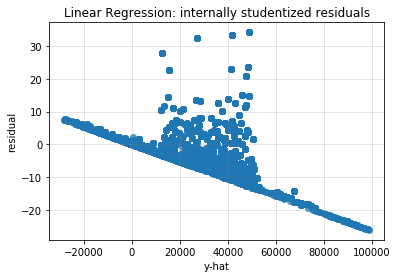

In [120]:
# on 20% of the entire dataset
ols(X, Y, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=False)

In [55]:
def equal_variance_test(data):
    all_samples = data.values
    print("Bartlette's test for equal variances:", bartlett(*all_samples))
    print("Levene's test:", levene(*all_samples, center='median'))
equal_variance_test(aggr_data_masterSKU)

Bartlette's test for equal variances: BartlettResult(statistic=31647157.223196078, pvalue=0.0)
Levene's test: LeveneResult(statistic=0.6536358905459718, pvalue=0.9999999999999999)


C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Method: OLS
RMSE: 14.279433020211519
Adjusted R2: 0.3534379055422899
MAPE :10.533770614115873%


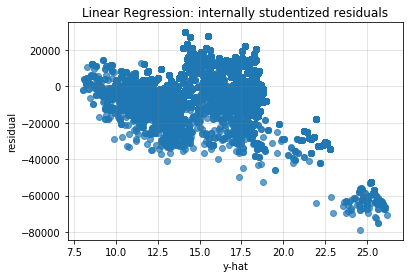

In [20]:
# on 20% data
ols(X, Y, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=True)

Method: OLS
RMSE: 1332902944.8023953
Adjusted R2: 0.2084568256619925
MAPE :436.14525095317475%


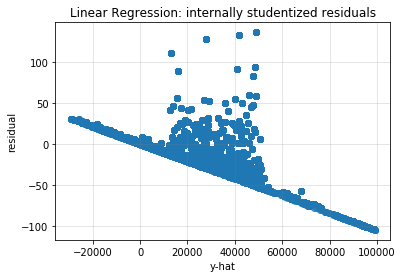

In [21]:
# on 80% of data
ols(X_80, Y_80, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=False)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Method: OLS
RMSE: 14.401486728683272
Adjusted R2: 0.35729036371400563
MAPE :10.786545288592363%


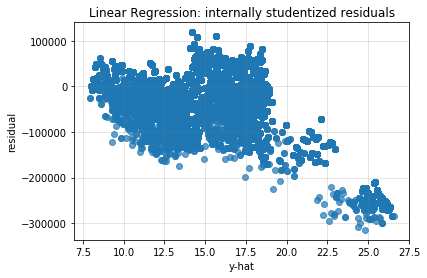

In [30]:
# on 80% of data
ols(X_80, Y_80, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=True)

### Polynomial regession

In [6]:
def polynomial_regression(X_, Y_, feature_list, d, boxcox_transform=False):
    
    if d == 2:
        type_ = 'quadratic'
    elif d == 3:
        type_ = 'cubic'
    elif d == 4:
        type_ = 'quartic'
    else:
        raise ValueError("degrees <= 4")
        
    # center and scale X; box-cox transform Y
    sc = StandardScaler()
    X_ = sc.fit_transform(X_)
    if boxcox_transform:   # may generate 0 in Y
        Y_, best_lambda = boxcox(Y_)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=0.2, random_state=12)
    
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=d)),
        ('linear', LinearRegression())
    ])
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    # cross validate & evaluate performance
    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, X, Y)
    
    print("Method: {}\nRMSE: {}\nAdjusted R2: {}\nMAPE:{}%".format(
        'Polynomial OLS regression', rmse, adj_r2, MAPE
    ))
    
    # calculate internally studentized residuals
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
    
    # visualize internally studentized residuals
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('{} polynomial OLS Regression\ninternally studentized residuals'.format(type_))
    ax1.set_ylabel('residual')
    ax1.set_xlabel('y-hat')

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Method: Polynomial OLS regression
RMSE: 987337117.3837744
Adjusted R2: 0.41743183421123414
MAPE:1164.0206160866069%


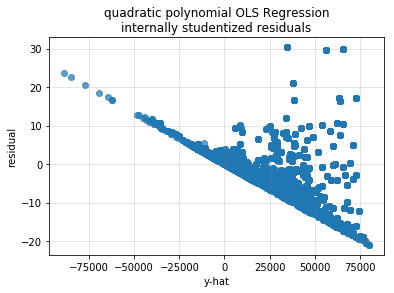

In [24]:
# on 20% data
polynomial_regression(X, Y, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], d=2, boxcox_transform=False)

In [ ]:
# on 20% data
polynomial_regression(X, Y, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], d=2, boxcox_transform=True)

Method: Polynomial OLS regression
RMSE: 8.064442949357735
Adjusted R2: 0.6348321050254128
MAPE (not cross validated):15.99643780901012%


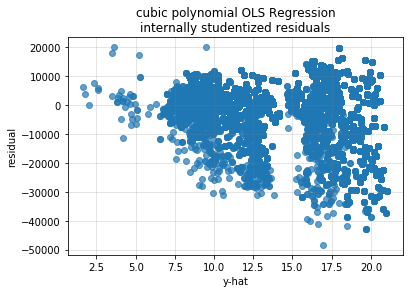

In [139]:
polynomial_regression(X, Y, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], d=3, boxcox_transform=True)

Method: Polynomial OLS regression
RMSE: 6.718424473302808
Adjusted R2: 0.6957256519528282
MAPE (not cross validated):14.436355774481434%


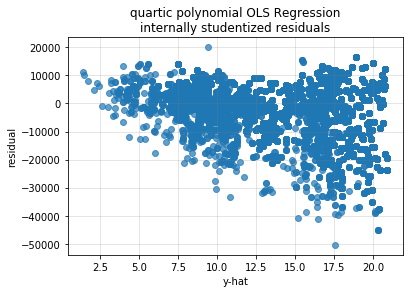

In [140]:
polynomial_regression(X, Y, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], d=4, boxcox_transform=True)

In [ ]:
polynomial_regression(X, Y, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], d=4, boxcox_transform=True)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
polynomial_regression(X_80, Y_80, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], d=3, boxcox_transform=True)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


MemoryError: 

### WLS
weighted least square (WLS) handles heteroskedasticity. 

In [112]:
def wls_sm(X_, Y_, feature_list, w, boxcox_transform=False):

    sc = StandardScaler()
    X_ = sc.fit_transform(X)
    if boxcox_transform:   # may generate 0 in Y; don't use if cause problem with MAPE
        Y_, best_lambda = boxcox(Y_)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

    # X_train = sm.add_constant(X_train)
    model = sm.WLS(Y_train, X_train, weight=w)
    result = model.fit()
    
    return result.summary()

In [133]:
def wls(X_, Y_, feature_list, boxcox_transform=False):

    sc = StandardScaler()
    X_ = sc.fit_transform(X_)
    if boxcox_transform:
        Y_, _ = boxcox(Y_)

    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=0.2, random_state=12)

    lr = LinearRegression()
    lr.fit(X_train, Y_train, sample_weight=[i**2 for i in range(1,len(X_train)+1)])
    Y_pred = lr.predict(X_test)
    
    rmse = np.mean(-1 * cross_val_score(lr, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(lr, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(lr, Y_test, Y_pred)
    
    print("Method: {}\nRMSE: {}\nAdjusted R2: {}\nMAPE :{}%".format(
        'OLS', rmse, adj_r2, MAPE))
    
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
    
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('Linear Regression: internally studentized residuals')
    ax1.set_ylabel('residual')
    ax1.set_xlabel('y-hat')

In [122]:
wls_sm(X, Y, ['ProductCategory', 'MasterSKU', 'dealer_volume_group', 'month'], w=[1/i for i in range(1,len(X)+1)])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.312
Model:                            WLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                 1.093e+04
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        16:38:43   Log-Likelihood:            -1.1639e+06
No. Observations:               96424   AIC:                         2.328e+06
Df Residuals:                   96420   BIC:                         2.328e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2080.5101    115.261    -18.050      0.000   -2306.420   -1854.601
x2          1063.5425     10.840     98.111      0.000    1042.296    1084.789
x3         -4942.1241    174.682    -28.292      0.000   -5284.498   -4599.750
x4          1325.4741     40.038     33.106      0.000    1247.001    1403.947
==============================================================================
Omnibus:                    25328.744   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57486.482
Skew:                           1.506   Prob(JB):                         0.00
Kurtosis:                       5.289   Cond. No.                         33.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Method: OLS
RMSE: 1344860518.6030436
Adjusted R2: 0.20636292713691387
MAPE :257.07525220085626%


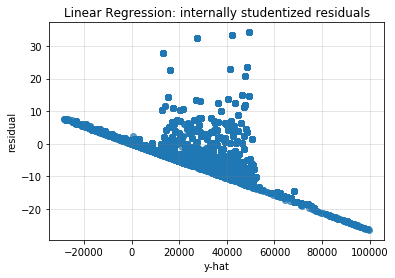

In [134]:
wls(X, Y, feature_list=['ProductCategory', 'MasterSKU', 'dealer_volume_group', 'month'])

### K-Nearest Neighbors

In [8]:
def local_knn(X_,Y_,lo,hi, boxcox_transform=False):
    
    normalize(X_, norm='l2', copy=False)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train = boxcox(Y_train)
        Y_test = boxcox(Y_test)
    
    # cross validate
    r2_list = []
    for k in range(lo, hi):
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(X_, Y_)    
        r2 = np.mean(cross_val_score(knn, X_, Y_, scoring='r2'))
        r2_list.append(r2)
    print("cross validated {} of values for K".format(len(r2_list)))
    
    n = len(X_)     # number of observations
    p = len(X_[0])  # number of features
    adj_r2_list = [calculate_adj_r2(r2, n, p) for r2 in r2_list]
    print("Best adjusted R2: {}".format(np.amax(adj_r2_list)))
    
    return adj_r2_list
    
# plot KNN results (adjusted R2)
def plot_knn_results(lo, hi, k_adj_r2):
    fig2, ax2 = plt.subplots()
    X2, Y2 = [k for k in range(lo, hi)], k_adj_r2
    ax2.plot(X2, Y2)
    plt.grid(color='grey',linestyle='-', linewidth=1, alpha=.2)
    ax2.set_title("KNN regressor ({} < k < {})".format(lo-1,hi))
    ax2.set_xlabel("number of neighbors")
    ax2.set_ylabel("Adjusted R2")

cross validated 48 of values for K
Best adjusted R2: 0.966278393793333


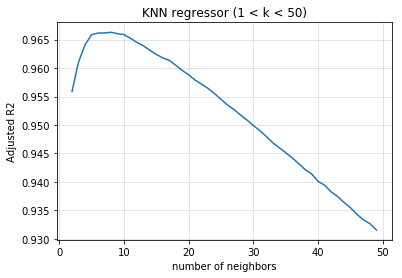

In [70]:
knn_adj_r2 = local_knn(X, Y, 2, 50)
plot_knn_results(2, 50, knn_adj_r2)

cross validated 8 of values for K
Best adjusted R2: 0.966278393793333


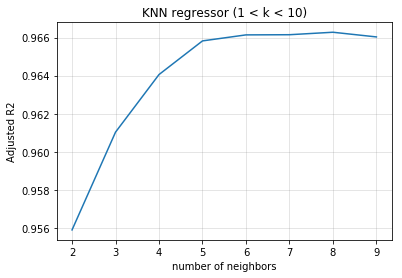

In [71]:
knn_adj_r2 = local_knn(X, Y, 2, 10)
plot_knn_results(2, 10, knn_adj_r2)

Based on this plot, select K = 8 when the model has the highest adjusted R2

In [9]:
# interally studentized residuals
def local_knn_resplot_studentized(X, Y, k, boxcox_transform=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train,_ = boxcox(Y_train)
        Y_test,_ = boxcox(Y_test)
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
     
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('knn regressor (k = {}) residuals'.format(k))
    ax1.set_ylabel('internally studentized residuals')
    ax1.set_xlabel('y-hat')

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


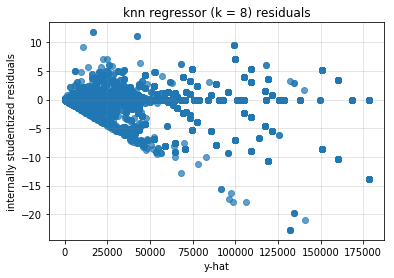

In [227]:
local_knn_resplot_studentized(X, Y, 8)

In [10]:
def local_knn_rmse(X_,Y_,lo,hi,boxcox_transform=False):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train = boxcox(Y_train)
        Y_test = boxcox(Y_test)
    
    # cross validate
    score_list = []
    for k in range(lo, hi):
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(X_, Y_)    
        rmse = np.sqrt(np.mean(-1 * cross_val_score(knn, X_, Y_, scoring='neg_mean_squared_error')))
        score_list.append(rmse)
    print("cross validated {} of values for K".format(len(score_list)))
    print("Best adjusted MSE: {}".format(np.amin(score_list)))
    
    return score_list
    
# plot KNN results (adj r2)
def plot_knn_results(lo, hi, score_list):
    fig2, ax2 = plt.subplots()
    X2, Y2 = [k for k in range(lo, hi)], score_list
    ax2.plot(X2, Y2)
    plt.grid(color='grey',linestyle='-', linewidth=1, alpha=.2)
    ax2.set_title("KNN regressor ({} < k < {})".format(lo-1,hi))
    ax2.set_xlabel("number of neighbors")
    ax2.set_ylabel("RMSE")

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


cross validated 48 of values for K
Best adjusted MSE: 7563.657245434612


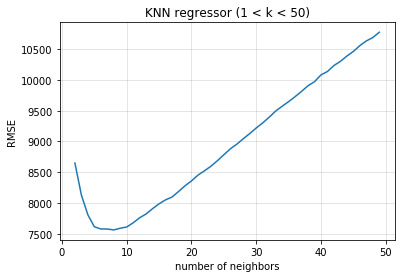

In [231]:
knn_rmse_result = local_knn_rmse(X,Y,2,50)
plot_knn_results(2,50,knn_rmse_result)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


cross validated 8 of values for K
Best adjusted MSE: 7563.657245434612


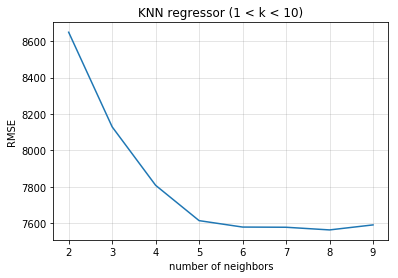

In [232]:
knn_rmse_result = local_knn_rmse(X,Y,2,10)
plot_knn_results(2,10,knn_rmse_result)

Based on the RMSE plot, the model achieves the best performance at K = 8

In [11]:
def cross_val_mape_knn(k, X_, Y_, fold=5, rand_seed=None):
    
    X_train, X_test, Y_train, Y_test = [],[],[],[]
    
    kf = KFold(n_splits=fold, random_state=rand_seed)
    for train_indices, test_indices in kf.split(X_, Y_):
        X_train, X_test = X_[train_indices], X_[test_indices]
        Y_train, Y_test = Y_[train_indices], Y_[test_indices]
    
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, Y_train)
    
    Y_pred = knn.predict(X_test)
    mape_score = mape(Y_test, Y_pred)
    
    return mape_score


def local_knn_mape(X_,Y_, lo, hi, boxcox_transform=False):
    
    # center and scale
    sc = StandardScaler()
    X_ = sc.fit_transform(X_)
    if boxcox_transform: 
        if lambda_ is None:
            Y_, bestlambda = boxcox(Y_)
            print("best lambda:", bestlambda)
        else:
            Y_ = boxcox(Y_, lmbda=lambda_)

    # cross validate
    score_list = []
    for k in range(lo, hi):
        score_list.append(cross_val_mape_knn(k, X_, Y_, rand_seed=19))

    return score_list

def plot_knn_results(lo, hi, score_list):
    fig2, ax2 = plt.subplots()
    X2, Y2 = [k for k in range(lo, hi)], score_list
    ax2.plot(X2, Y2)
    plt.grid(color='grey',linestyle='-', linewidth=1, alpha=.2)
    ax2.set_title("KNN regressor ({} < k < {})".format(lo-1,hi))
    ax2.set_xlabel("number of neighbors")
    ax2.set_ylabel("MAPE (percentage)")

In [ ]:
knn_mape_results = local_knn_mape(X, Y, 2, 50)

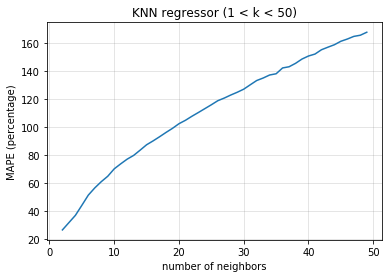

In [240]:
plot_knn_results(2, 50, knn_mape_results)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


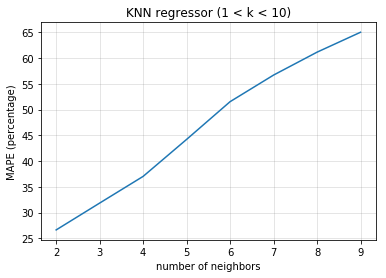

In [242]:
KNN_mape_results_small = local_knn_mape(X, Y, 2, 10)
plot_knn_results(2,10,KNN_mape_results_small)

In [12]:
def knn_final(X_, Y_, k, feature_list=None, boxcox_transform=False):
    
    sc = StandardScaler()
    X_ = sc.fit_transform(X)
    if boxcox_transform:
        Y_, _ = boxcox(Y_)
        
    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_,
                                                        test_size=0.3,
                                                        random_state=12)

    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, Y_train)
    
    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = np.mean(cross_val_mape(model, X, Y))
    
    print("KNN with K = {} \n \
        features considered at each split: all \n \
        RMSE: {} \n Adjusted R2: {} \n \
        MAPE: {}%".format(k, rmse, adj_r2, MAPE))

In [175]:
knn_final(X, Y, 2, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=False)

KNN with K = 2 
         features considered at each split: all 
         RMSE: 140776342.69879526 
 Adjusted R2: 0.9148184016238744 
         MAPE: 26.37392545599712%


In [176]:
knn_final(X, Y, 2, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=True)

MemoryError: 

In [14]:
knn_final(X, Y, 8, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=False)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KNN with K = 8 
         features considered at each split: all 
         RMSE: 94921418.1065645 
 Adjusted R2: 0.939740647722528 
         MAPE: 44.680046145897286%


In [ ]:
knn_final(X, Y, 8, feature_list=['ProductCategory', 'MasterSKU',
                    'dealer_volume_group', 'month'], boxcox_transform=True)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Ensemble - Random Forest
Tree-based methods have the following advantages over linear methods:
- similar to KNN regressor, they can model highly non-linear and complex relationships;
- better than KNN regressor, their results and decision process is interpretable; and 
- mirroring human decision process, trees are intuitive to understand and provide good graphics for visualization.

Cons:
- A single decision trees have high variance and are prone to overfit.
- As a result, tree-based methods ofen give less accurate predictions when the true relationship is close to linear.
- Non-robust: small changes in the data can lead to large changes in final estimates.


The random forest regressor fits a number of decision trees on various sub-samples of the data, and then use averages to improve accuracy and control overfitting. 

Pros:
- Improves prediction accuracy over single decision tree
- A highly flexible method with high complexity.

Cons:
- no longer interpretable
- there's still the risk of overfitting; it takes much more efforts to construct, tune and train.
- requires more computational resources: time-consuming to train and predict.

In [13]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

def random_forest_reg(X_, Y_, max_depth=3, feature_list=None, boxcox_transform=False):
    
    """ memory-intesive mod """
    """ the random forest regressor is paralleled using all CPU cores """
    
    sc = StandardScaler()
    X_ = sc.fit_transform(X_)
    if boxcox_transform:
        Y_, _ = boxcox(Y_)

    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_,
                                                        test_size=0.2,
                                                        random_state=12)

    model = RandomForestRegressor(bootstrap=True,random_state=0,
                                 max_depth=max_depth,n_jobs=-1)
    model.fit(X_train, np.ravel(Y_train))

    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = np.mean(cross_val_mape(model, X, Y))
    
    print("Random Forest with max depth = {}\n \
        features considered at each split: all \n \
        RMSE: {} \n \
        Adjusted R2: {}\n \
        MAPE:{}%".format(max_depth,rmse,adj_r2,MAPE))
    

In [164]:
# no Box-Cox transformation, max_depth = 3
random_forest_reg(X, Y, feature_list= ['ProductCategory', 'MasterSKU', 'Color', 'dealer_volume_group', 'month'])

Random Forest with max depth = 3
         features considered at each split: all 
         RMSE: 674209676.7525152 
         Adjusted R2: 0.6027201447284973
         MAPE:2660.751049858898%


In [165]:
random_forest_reg(X, Y, 
                  feature_list=['ProductCategory', 'MasterSKU', 'Color', 'dealer_volume_group', 'month'], 
                  boxcox_transform=True)

Random Forest with max depth = 3
         features considered at each split: all 
         RMSE: 6.434668981911645 
         Adjusted R2: 0.7107796918918051
         MAPE:15.254747660346185%


In [23]:
random_forest_reg(X, Y, max_depth=4, 
                  feature_list= ['ProductCategory', 'MasterSKU', 'Color', 'dealer_volume_group', 'month'])

Random Forest with max depth = 4
         features considered at each split: all 
         RMSE: 538355682.6773136 
         Adjusted R2: 0.682674236379138
         MAPE (not cross validated):2598.659323843676%


In [166]:
random_forest_reg(X, Y, max_depth=5,
                  feature_list= ['ProductCategory', 'MasterSKU', 'Color', 'dealer_volume_group', 'month'], 
                 boxcox_transform = True)

Random Forest with max depth = 5
         features considered at each split: all 
         RMSE: 3.8635699196307884 
         Adjusted R2: 0.8272801188714981
         MAPE:11.348832380403662%


In [28]:
random_forest_reg(X, Y, max_depth=8,
                  feature_list= ['ProductCategory', 'MasterSKU', 'Color', 'dealer_volume_group', 'month'])

Random Forest with max depth = 8
         features considered at each split: all 
         RMSE: 167603620.19329026 
         Adjusted R2: 0.9015302195658906
         MAPE (not cross validated):2607.960624636037%


In [167]:
random_forest_reg(X, Y, max_depth=None,
                  feature_list= ['ProductCategory', 'MasterSKU', 'Color', 'dealer_volume_group', 'month'],
                 boxcox_transform=True)

Random Forest with max depth = None
         features considered at each split: all 
         RMSE: 0.457958466511711 
         Adjusted R2: 0.9791507369960565
         MAPE:2.584979641170958%


## test models on June 2018 data

In [75]:
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=ezeng;PWD=Ed1tH2EnG#")
cursor = conn.cursor()

qry1 = """
SELECT S.CustomerID, C.Customer, S.OrderDate, S.Requested_Date, S.SalesOffice, S.OrderQty, P.ProductCategory, P.MasterSKU
FROM EDW_DS.ORDERFCT S 
inner join [EDW].[PRODUCT_DIM] P ON P.ProductID = S.ProductID 
left join EDW_DS.CUSTOMER_DIM C on S.CustomerID = C.CustomerID
WHERE P.ISCORE = 'TRUE' and S.SalesOffice in ('STD','HYB') 
and S.RejectionReason is null
and S.Ordertype Not in ('ZARF','ZARM','ZEG2','ZERF','ZERM','ZRE') and S.SoldtoParty not in ('91860','0000107894','0000114883','0000108654')
and S.OrderDate >= '2018-06-01' and S.OrderDate <= '2018-06-30'
order by OrderDate ASC
"""

test_data = pd.read_sql(qry1, conn)
test_data['CustomerID'] = test_data['CustomerID'].apply(lambda x: x.zfill(10))

In [76]:
%store -r volume_groups
def add_test_data_cols():
    test_data['dealer_volume_group'] = test_data.apply(lambda _: '', axis=1)
    for i, row in test_data.iterrows():
        try: 
            test_data.at[i, 'dealer_volume_group'] = volume_groups[row[0]]
        except KeyError:   # skip new dealers
            continue
add_test_data_cols()
test_data.columns

Index(['CustomerID', 'Customer', 'OrderDate', 'Requested_Date', 'SalesOffice',
       'OrderQty', 'ProductCategory', 'MasterSKU', 'dealer_volume_group'],
      dtype='object')

In [77]:
test_data.drop(columns=['CustomerID', 'Customer','OrderDate','Requested_Date', 'SalesOffice'], inplace=True)
test_data.columns

Index(['OrderQty', 'ProductCategory', 'MasterSKU', 'dealer_volume_group'], dtype='object')

In [78]:
def update_monthly_sum(dFrame):
            
    new_dFrame = dFrame.copy()
    new_dFrame['monthly_sum_Order_Qty'] = np.nan
    hi = len(dFrame)

    for i, row in dFrame.iterrows():
        
        subset = dFrame.loc[(dFrame['MasterSKU'] == row[2])
                            & (dFrame['dealer_volume_group'] == row[3])]
        
        subset_order_sum = subset['OrderQty'].sum(min_count=1)

        new_dFrame.loc[(
                        (np.isnan(new_dFrame['monthly_sum_Order_Qty']))
                        & (dFrame['MasterSKU'] == row[2])
                        & (dFrame['dealer_volume_group'] == row[3])
                        ), 'monthly_sum_Order_Qty'] = subset_order_sum
            
        if (i % 1000) == 0 and i <= hi:
            sys.stdout.write('\r'+"{0:.3%}".format(i/hi))
            sys.stdout.flush()
            
    return new_dFrame

def encode_categorical_predictors(dFrame):
    op = dFrame.copy()
    le = LabelEncoder()
    for c in ['ProductCategory', 'MasterSKU']:
        op[c] = le.fit_transform(op[c].astype(str))
    return op

In [79]:
df = update_monthly_sum(test_data)

99.547%

In [23]:
df_num = encode_categorical_predictors(df)
df_num['month'] = df.apply(lambda _:6, axis=1)
df_num['dealer_volume_group'] = pd.to_numeric(df_num['dealer_volume_group'])
df_num['dealer_volume_group'] = df_num['dealer_volume_group'].fillna(value=-1)

In [92]:
test_data_X = df_num[['ProductCategory','MasterSKU','dealer_volume_group', 'month']].values
test_data_Y = df_num['monthly_sum_Order_Qty'].values.reshape(-1,1)

In [108]:
def knn_test(X, Y, test_data_X, test_data_Y, k=21, feature_list=None, boxcox_transform=False):
    sc = StandardScaler(X)
    X = sc.fit_transform(X)
    X_test = sc.transform(test_data_X)

    if boxcox_transform:
        Y, best_lambda = boxcox(Y)
        Y_test = boxcox(test_data_Y)
    else:
        Y_test = test_data_Y

    X_train, Y_train = X, Y

    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    
    Y_pred = knn.predict(X_test)
    
    rmse = np.mean(-1 * cross_val_score(knn, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(knn, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(knn, Y_test, Y_pred)
    
    print("KNN with K = {} \n \
        features considered at each split: all \n \
        RMSE: {} \n Adjusted R2: {} \n \
        MAPE: {}%".format(k, rmse, adj_r2, MAPE))
    
def random_forest_test(X, Y, test_data_X, test_data_Y, max_depth=None, feature_list=None, boxcox_transform=False):

    sc = StandardScaler()
    X = sc.fit_transform(X)
    X_test = sc.transform(test_data_X)
    
    if boxcox_transform:
        Y, best_lambda = boxcox(Y)
        Y_test = boxcox(test_data_Y,lmbda=best_lambda)
    else:
        Y_test = test_data_Y.reshape
    
    X_train, Y_train = X, Y
    model = RandomForestRegressor(bootstrap=True,random_state=0,max_depth=max_depth,n_jobs=-1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, Y_test, Y_pred) # not enough memory to calculate this for Random Forest
    
    print("Features:", feature_list)
    print("Random Forest with max depth = {}\n \
        features considered at each split: all \n \
        RMSE: {} \n Adjusted R2: {}\nMAPE: {}%".format(max_depth,rmse,adj_r2,MAPE))

def poly_reg_test(X, Y, test_data_X, test_data_Y, feature_list, d, boxcox_transform=False):
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    X_train, Y_train = X, Y
    X_test = sc.transform(test_data_X)    
    if boxcox_transform:
        Y, best_lambda = boxcox(Y)
        Y_test = boxcox(test_data_Y).reshape(-1,1)
    else:
        Y_test = test_data_Y.reshape(-1,1)
    
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=d)),
        ('linear', LinearRegression())
    ])
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test).reshape(-1,1)
    
    # cross validate & evaluate performance
    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, Y_test, Y_pred)
    
    print("Method: {} degree: {} \nRMSE: {}\n\
        Adjusted R2: {}\nMAPE :{}%".format(
        'Polynomial OLS', d, rmse, adj_r2, MAPE
    ))
    
    # calculate internally studentized residuals
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
    
    # visualize internally studentized residuals
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('Polynomial Linear Regression, degree = {}\ninternally studentized residuals'.format(d))
    ax1.set_ylabel('residual')
    ax1.set_xlabel('y-hat')

In [94]:
X.shape

(120530, 4)

In [95]:
test_data_X.shape

(31141, 4)

Method: Polynomial OLS degree: 1 
RMSE: 1344134846.4384043
        Adjusted R2: 0.20779310490291358
MAPE :182.47379905391676%


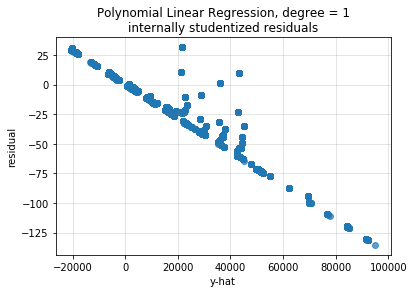

In [106]:
poly_reg_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','MasterSKU','dealer_volume_group', 'month'], d=1, boxcox_transform=False)

In [109]:
poly_reg_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','MasterSKU','dealer_volume_group', 'month'], d=1, boxcox_transform=True)

ValueError: Data must be positive.

Method: Polynomial OLS degree: 3 
RMSE: 943602133.1578591
        Adjusted R2: 0.4437232730184671
MAPE :216.6904503000358%


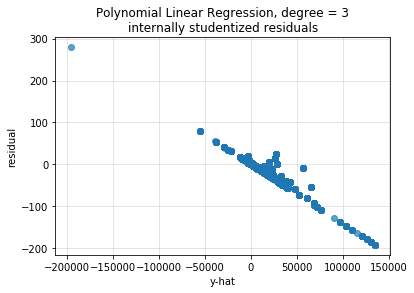

In [97]:
poly_reg_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','MasterSKU','dealer_volume_group', 'month'], d=3, boxcox_transform=False)

Method: Polynomial OLS degree: 4 
RMSE: 871656820.0236738
        Adjusted R2: 0.48624746659529633
MAPE :234631585.33617342%


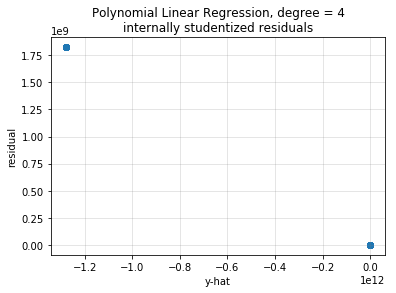

In [96]:
poly_reg_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','MasterSKU','dealer_volume_group', 'month'], d=4, boxcox_transform=False)

In [110]:
knn_test(X, Y, test_data_X, test_data_Y, k=8, feature_list=['ProductCategory','dealer_volume_group', 'month'], boxcox_transform=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [91]:
random_forest_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','dealer_volume_group', 'month'], boxcox_transform=True)

ValueError: Data must be positive.